## 1. Import libraries <a class="anchor" id="1"></a>

[Back to Table of Contents](#0.1)

In [1]:
# !pip install ../input/kerasapplications/keras-team-keras-applications-3b180cb -f ./ --no-index
# !pip install ../input/efficientnet/efficientnet-1.1.0/ -f ./ --no-index

In [2]:
# kaggle
#WEIGHTS_PATH = "../input/osic-model-weights/"
#INPUT_PATH = "../input/osic-pulmonary-fibrosis-progression"

# devbox
WEIGHTS_PATH = "../../weights/public/efficientnet-khoong/"
INPUT_PATH = "../../data/original_v2"

In [3]:
import os
import cv2
import pydicom
import pandas as pd
import numpy as np
import tensorflow as tf 
import matplotlib.pyplot as plt 
import random
from tqdm.notebook import tqdm 
from sklearn.model_selection import train_test_split, KFold
from sklearn.metrics import mean_absolute_error
from tensorflow_addons.optimizers import RectifiedAdam
from tensorflow.keras import Model
import tensorflow.keras.backend as K
import tensorflow.keras.layers as L
import tensorflow.keras.models as M
from tensorflow.keras.optimizers import Nadam
import seaborn as sns
import plotly.express as px
import plotly.graph_objects as go
from PIL import Image
from collections import defaultdict

In [4]:
tf.config.list_physical_devices('GPU')

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU'),
 PhysicalDevice(name='/physical_device:GPU:1', device_type='GPU')]

In [5]:
tf.test.gpu_device_name()

'/device:GPU:0'

In [6]:
def seed_everything(seed=2020):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    tf.random.set_seed(seed)

In [7]:
seed_everything(42)

In [8]:
config = tf.compat.v1.ConfigProto()
config.gpu_options.allow_growth = True
session = tf.compat.v1.Session(config=config)

## 4.2 Osic-Multiple-Quantile-Regression <a class="anchor" id="4.2"></a>

[Back to Table of Contents](#0.1)

In [9]:
BATCH_SIZE=128

tr = pd.read_csv(f"{INPUT_PATH}/train.csv")
tr.drop_duplicates(keep=False, inplace=True, subset=['Patient','Weeks'])
chunk = pd.read_csv(f"{INPUT_PATH}/test.csv")

print("add infos")
sub = pd.read_csv(f"{INPUT_PATH}/sample_submission.csv")
sub['Patient'] = sub['Patient_Week'].apply(lambda x:x.split('_')[0])
sub['Weeks'] = sub['Patient_Week'].apply(lambda x: int(x.split('_')[-1]))
sub =  sub[['Patient','Weeks','Confidence','Patient_Week']]
sub = sub.merge(chunk.drop('Weeks', axis=1), on="Patient")

add infos


In [10]:
sub

,Patient,Weeks,Confidence,Patient_Week,FVC,Percent,Age,Sex,SmokingStatus
0,ID00419637202311204720264,-12,100,ID00419637202311204720264_-12,3020,70.186855,73,Male,Ex-smoker
1,ID00419637202311204720264,-11,100,ID00419637202311204720264_-11,3020,70.186855,73,Male,Ex-smoker
2,ID00419637202311204720264,-10,100,ID00419637202311204720264_-10,3020,70.186855,73,Male,Ex-smoker
3,ID00419637202311204720264,-9,100,ID00419637202311204720264_-9,3020,70.186855,73,Male,Ex-smoker
4,ID00419637202311204720264,-8,100,ID00419637202311204720264_-8,3020,70.186855,73,Male,Ex-smoker
...,...,...,...,...,...,...,...,...,...
725,ID00426637202313170790466,129,100,ID00426637202313170790466_129,2925,71.824968,73,Male,Never smoked
726,ID00426637202313170790466,130,100,ID00426637202313170790466_130,2925,71.824968,73,Male,Never smoked
727,ID00426637202313170790466,131,100,ID00426637202313170790466_131,2925,71.824968,73,Male,Never smoked
728,ID00426637202313170790466,132,100,ID00426637202313170790466_132,2925,71.824968,73,Male,Never smoked


In [11]:
tr['WHERE'] = 'train'
chunk['WHERE'] = 'val'
sub['WHERE'] = 'test'
data = tr.append([chunk, sub])

In [12]:
data

,Patient,Weeks,FVC,Percent,Age,Sex,SmokingStatus,WHERE,Confidence,Patient_Week
0,ID00007637202177411956430,-4,2315,58.253649,79,Male,Ex-smoker,train,NaN,NaN
1,ID00007637202177411956430,5,2214,55.712129,79,Male,Ex-smoker,train,NaN,NaN
2,ID00007637202177411956430,7,2061,51.862104,79,Male,Ex-smoker,train,NaN,NaN
3,ID00007637202177411956430,9,2144,53.950679,79,Male,Ex-smoker,train,NaN,NaN
4,ID00007637202177411956430,11,2069,52.063412,79,Male,Ex-smoker,train,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...
725,ID00426637202313170790466,129,2925,71.824968,73,Male,Never smoked,test,100.0,ID00426637202313170790466_129
726,ID00426637202313170790466,130,2925,71.824968,73,Male,Never smoked,test,100.0,ID00426637202313170790466_130
727,ID00426637202313170790466,131,2925,71.824968,73,Male,Never smoked,test,100.0,ID00426637202313170790466_131
728,ID00426637202313170790466,132,2925,71.824968,73,Male,Never smoked,test,100.0,ID00426637202313170790466_132


In [13]:
print(tr.shape, chunk.shape, sub.shape, data.shape)
print(tr.Patient.nunique(), chunk.Patient.nunique(), sub.Patient.nunique(), 
      data.Patient.nunique())

(1535, 8) (5, 8) (730, 10) (2270, 10)
176 5 5 176


In [14]:
data['min_week'] = data['Weeks']
data.loc[data.WHERE=='test','min_week'] = np.nan
data['min_week'] = data.groupby('Patient')['min_week'].transform('min')

In [15]:
data

,Patient,Weeks,FVC,Percent,Age,Sex,SmokingStatus,WHERE,Confidence,Patient_Week,min_week
0,ID00007637202177411956430,-4,2315,58.253649,79,Male,Ex-smoker,train,NaN,NaN,-4.0
1,ID00007637202177411956430,5,2214,55.712129,79,Male,Ex-smoker,train,NaN,NaN,-4.0
2,ID00007637202177411956430,7,2061,51.862104,79,Male,Ex-smoker,train,NaN,NaN,-4.0
3,ID00007637202177411956430,9,2144,53.950679,79,Male,Ex-smoker,train,NaN,NaN,-4.0
4,ID00007637202177411956430,11,2069,52.063412,79,Male,Ex-smoker,train,NaN,NaN,-4.0
...,...,...,...,...,...,...,...,...,...,...,...
725,ID00426637202313170790466,129,2925,71.824968,73,Male,Never smoked,test,100.0,ID00426637202313170790466_129,0.0
726,ID00426637202313170790466,130,2925,71.824968,73,Male,Never smoked,test,100.0,ID00426637202313170790466_130,0.0
727,ID00426637202313170790466,131,2925,71.824968,73,Male,Never smoked,test,100.0,ID00426637202313170790466_131,0.0
728,ID00426637202313170790466,132,2925,71.824968,73,Male,Never smoked,test,100.0,ID00426637202313170790466_132,0.0


In [16]:
data.loc[data.Weeks == data.min_week]

,Patient,Weeks,FVC,Percent,Age,Sex,SmokingStatus,WHERE,Confidence,Patient_Week,min_week
0,ID00007637202177411956430,-4,2315,58.253649,79,Male,Ex-smoker,train,NaN,NaN,-4.0
9,ID00009637202177434476278,8,3660,85.282878,69,Male,Ex-smoker,train,NaN,NaN,8.0
18,ID00010637202177584971671,0,3523,94.724672,60,Male,Ex-smoker,train,NaN,NaN,0.0
27,ID00011637202177653955184,6,3326,85.987590,72,Male,Ex-smoker,train,NaN,NaN,6.0
36,ID00012637202177665765362,33,3418,93.726006,65,Male,Never smoked,train,NaN,NaN,33.0
...,...,...,...,...,...,...,...,...,...,...,...
18,ID00419637202311204720264,6,3020,70.186855,73,Male,Ex-smoker,test,100.0,ID00419637202311204720264_6,6.0
173,ID00421637202311550012437,15,2739,82.045291,68,Male,Ex-smoker,test,100.0,ID00421637202311550012437_15,15.0
310,ID00422637202311677017371,6,1930,76.672493,73,Male,Ex-smoker,test,100.0,ID00422637202311677017371_6,6.0
467,ID00423637202312137826377,17,3294,79.258903,72,Male,Ex-smoker,test,100.0,ID00423637202312137826377_17,17.0


Если начальных измерений несколько, оставляется только одно

In [17]:
len(data['Patient'].unique())

176

In [18]:
base = data.loc[data.Weeks == data.min_week]
base = base[['Patient','FVC']].copy()
base.columns = ['Patient','min_FVC']
base['nb'] = 1
base['nb'] = base.groupby('Patient')['nb'].transform('cumsum')
base = base[base.nb==1]
base.drop('nb', axis=1, inplace=True)

In [19]:
base

,Patient,min_FVC
0,ID00007637202177411956430,2315
9,ID00009637202177434476278,3660
18,ID00010637202177584971671,3523
27,ID00011637202177653955184,3326
36,ID00012637202177665765362,3418
...,...,...
1504,ID00419637202311204720264,3020
1513,ID00421637202311550012437,2739
1523,ID00422637202311677017371,1930
1531,ID00423637202312137826377,3294


In [20]:
data = data.merge(base, on='Patient', how='left')
data['base_week'] = data['Weeks'] - data['min_week']
del base

In [21]:
COLS = ['Sex','SmokingStatus'] #,'Age'
FE = []
for col in COLS:
    for mod in data[col].unique():
        FE.append(mod)
        data[mod] = (data[col] == mod).astype(int)

In [22]:
#
data['age'] = (data['Age'] - data['Age'].min() ) / ( data['Age'].max() - data['Age'].min() )
data['BASE'] = (data['min_FVC'] - data['min_FVC'].min() ) / ( data['min_FVC'].max() - data['min_FVC'].min() )
data['week'] = (data['base_week'] - data['base_week'].min() ) / ( data['base_week'].max() - data['base_week'].min() )
data['percent'] = (data['Percent'] - data['Percent'].min() ) / ( data['Percent'].max() - data['Percent'].min() )
FE += ['age','percent','week','BASE']

In [23]:
data

,Patient,Weeks,FVC,Percent,Age,Sex,SmokingStatus,WHERE,Confidence,Patient_Week,...,base_week,Male,Female,Ex-smoker,Never smoked,Currently smokes,age,BASE,week,percent
0,ID00007637202177411956430,-4,2315,58.253649,79,Male,Ex-smoker,train,NaN,NaN,...,0.0,1,0,1,0,0,0.769231,0.241456,0.179012,0.236393
1,ID00007637202177411956430,5,2214,55.712129,79,Male,Ex-smoker,train,NaN,NaN,...,9.0,1,0,1,0,0,0.769231,0.241456,0.234568,0.215941
2,ID00007637202177411956430,7,2061,51.862104,79,Male,Ex-smoker,train,NaN,NaN,...,11.0,1,0,1,0,0,0.769231,0.241456,0.246914,0.184960
3,ID00007637202177411956430,9,2144,53.950679,79,Male,Ex-smoker,train,NaN,NaN,...,13.0,1,0,1,0,0,0.769231,0.241456,0.259259,0.201767
4,ID00007637202177411956430,11,2069,52.063412,79,Male,Ex-smoker,train,NaN,NaN,...,15.0,1,0,1,0,0,0.769231,0.241456,0.271605,0.186580
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2265,ID00426637202313170790466,129,2925,71.824968,73,Male,Never smoked,test,100.0,ID00426637202313170790466_129,...,129.0,1,0,0,1,0,0.615385,0.354755,0.975309,0.345604
2266,ID00426637202313170790466,130,2925,71.824968,73,Male,Never smoked,test,100.0,ID00426637202313170790466_130,...,130.0,1,0,0,1,0,0.615385,0.354755,0.981481,0.345604
2267,ID00426637202313170790466,131,2925,71.824968,73,Male,Never smoked,test,100.0,ID00426637202313170790466_131,...,131.0,1,0,0,1,0,0.615385,0.354755,0.987654,0.345604
2268,ID00426637202313170790466,132,2925,71.824968,73,Male,Never smoked,test,100.0,ID00426637202313170790466_132,...,132.0,1,0,0,1,0,0.615385,0.354755,0.993827,0.345604


In [24]:
tr = data.loc[data.WHERE=='train']
chunk = data.loc[data.WHERE=='val']
sub = data.loc[data.WHERE=='test']
del data

In [25]:
tr.shape, chunk.shape, sub.shape

((1535, 22), (5, 22), (730, 22))

## 4.3 The change of mloss <a class="anchor" id="4.3"></a>

[Back to Table of Contents](#0.1)

In [26]:
C1, C2 = tf.constant(70, dtype='float32'), tf.constant(1000, dtype="float32")

def score(y_true, y_pred):
    tf.dtypes.cast(y_true, tf.float32)
    tf.dtypes.cast(y_pred, tf.float32)
    sigma = y_pred[:, 2] - y_pred[:, 0]
    fvc_pred = y_pred[:, 1]
    
    #sigma_clip = sigma + C1
    sigma_clip = tf.maximum(sigma, C1)
    delta = tf.abs(y_true[:, 0] - fvc_pred)
    delta = tf.minimum(delta, C2)
    sq2 = tf.sqrt( tf.dtypes.cast(2, dtype=tf.float32) )
    metric = (delta / sigma_clip)*sq2 + tf.math.log(sigma_clip* sq2)
    return K.mean(metric)

def qloss(y_true, y_pred):
    # Pinball loss for multiple quantiles
    qs = [0.2, 0.50, 0.8]
    q = tf.constant(np.array([qs]), dtype=tf.float32)
    e = y_true - y_pred
    v = tf.maximum(q*e, (q-1)*e)
    return K.mean(v)

def mloss(_lambda):
    def loss(y_true, y_pred):
        return _lambda * qloss(y_true, y_pred) + (1 - _lambda)*score(y_true, y_pred)
    return loss

def make_model(nh):
    z = L.Input((nh,), name="Patient")
    x = L.Dense(100, activation="relu", name="d1")(z)
    x = L.Dense(100, activation="relu", name="d2")(x)
    p1 = L.Dense(3, activation="linear", name="p1")(x)
    p2 = L.Dense(3, activation="relu", name="p2")(x)
    preds = L.Lambda(lambda x: x[0] + tf.cumsum(x[1], axis=1), 
                     name="preds")([p1, p2])
    
    model = M.Model(z, preds, name="CNN")
    model.compile(loss=mloss(0.65), optimizer=tf.keras.optimizers.Adam(lr=0.1, beta_1=0.9, beta_2=0.999, epsilon=None, decay=0.01, amsgrad=False), metrics=[score])
    return model

In [27]:
y = tr['FVC'].values
z = tr[FE].values
ze = sub[FE].values
nh = z.shape[1]
pe = np.zeros((ze.shape[0], 3))
pred = np.zeros((z.shape[0], 3))

In [28]:
FE

['Male',
 'Female',
 'Ex-smoker',
 'Never smoked',
 'Currently smokes',
 'age',
 'percent',
 'week',
 'BASE']

In [29]:
z.shape

(1535, 9)

In [30]:
net = make_model(nh)
print(net.summary())
print(net.count_params())

Model: "CNN"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
Patient (InputLayer)            [(None, 9)]          0                                            
__________________________________________________________________________________________________
d1 (Dense)                      (None, 100)          1000        Patient[0][0]                    
__________________________________________________________________________________________________
d2 (Dense)                      (None, 100)          10100       d1[0][0]                         
__________________________________________________________________________________________________
p1 (Dense)                      (None, 3)            303         d2[0][0]                         
________________________________________________________________________________________________

In [31]:
NFOLD = 5 # originally 5
kf = KFold(n_splits=NFOLD)

In [32]:
%%time
cnt = 0
EPOCHS = 800
for tr_idx, val_idx in kf.split(z):
    cnt += 1
    print(f"FOLD {cnt}")
    net = make_model(nh)
    net.fit(z[tr_idx], y[tr_idx], batch_size=BATCH_SIZE, epochs=EPOCHS, 
            validation_data=(z[val_idx], y[val_idx]), verbose=0) #
    print("train", net.evaluate(z[tr_idx], y[tr_idx], verbose=0, batch_size=BATCH_SIZE))
    print("val", net.evaluate(z[val_idx], y[val_idx], verbose=0, batch_size=BATCH_SIZE))
    print("predict val...")
    pred[val_idx] = net.predict(z[val_idx], batch_size=BATCH_SIZE, verbose=0)
    print("predict test...")
    pe += net.predict(ze, batch_size=BATCH_SIZE, verbose=0) / NFOLD

FOLD 1
train [34.08563995361328, 6.510558128356934]
val [40.815616607666016, 6.833072662353516]
predict val...
predict test...
FOLD 2
train [33.67403030395508, 6.507484436035156]
val [39.78080749511719, 6.682243824005127]
predict val...
predict test...
FOLD 3
train [33.22452163696289, 6.462821006774902]
val [46.197296142578125, 6.7050557136535645]
predict val...
predict test...
FOLD 4
train [32.65989685058594, 6.480105400085449]
val [36.22709655761719, 6.558115482330322]
predict val...
predict test...
FOLD 5
train [33.01238250732422, 6.4776201248168945]
val [39.478355407714844, 6.6687798500061035]
predict val...
predict test...
CPU times: user 3min 44s, sys: 14.2 s, total: 3min 58s
Wall time: 2min 58s


In [33]:
print(pred.shape)
pred[0]

(1535, 3)


array([2062.72802734, 2202.17895508, 2308.39355469])

In [34]:
sigma_opt = mean_absolute_error(y, pred[:, 1])
unc = pred[:,2] - pred[:, 0]
sigma_mean = np.mean(unc)
print(sigma_opt, sigma_mean)

141.59997160970582 233.67313379542446


In [35]:
y.shape

(1535,)

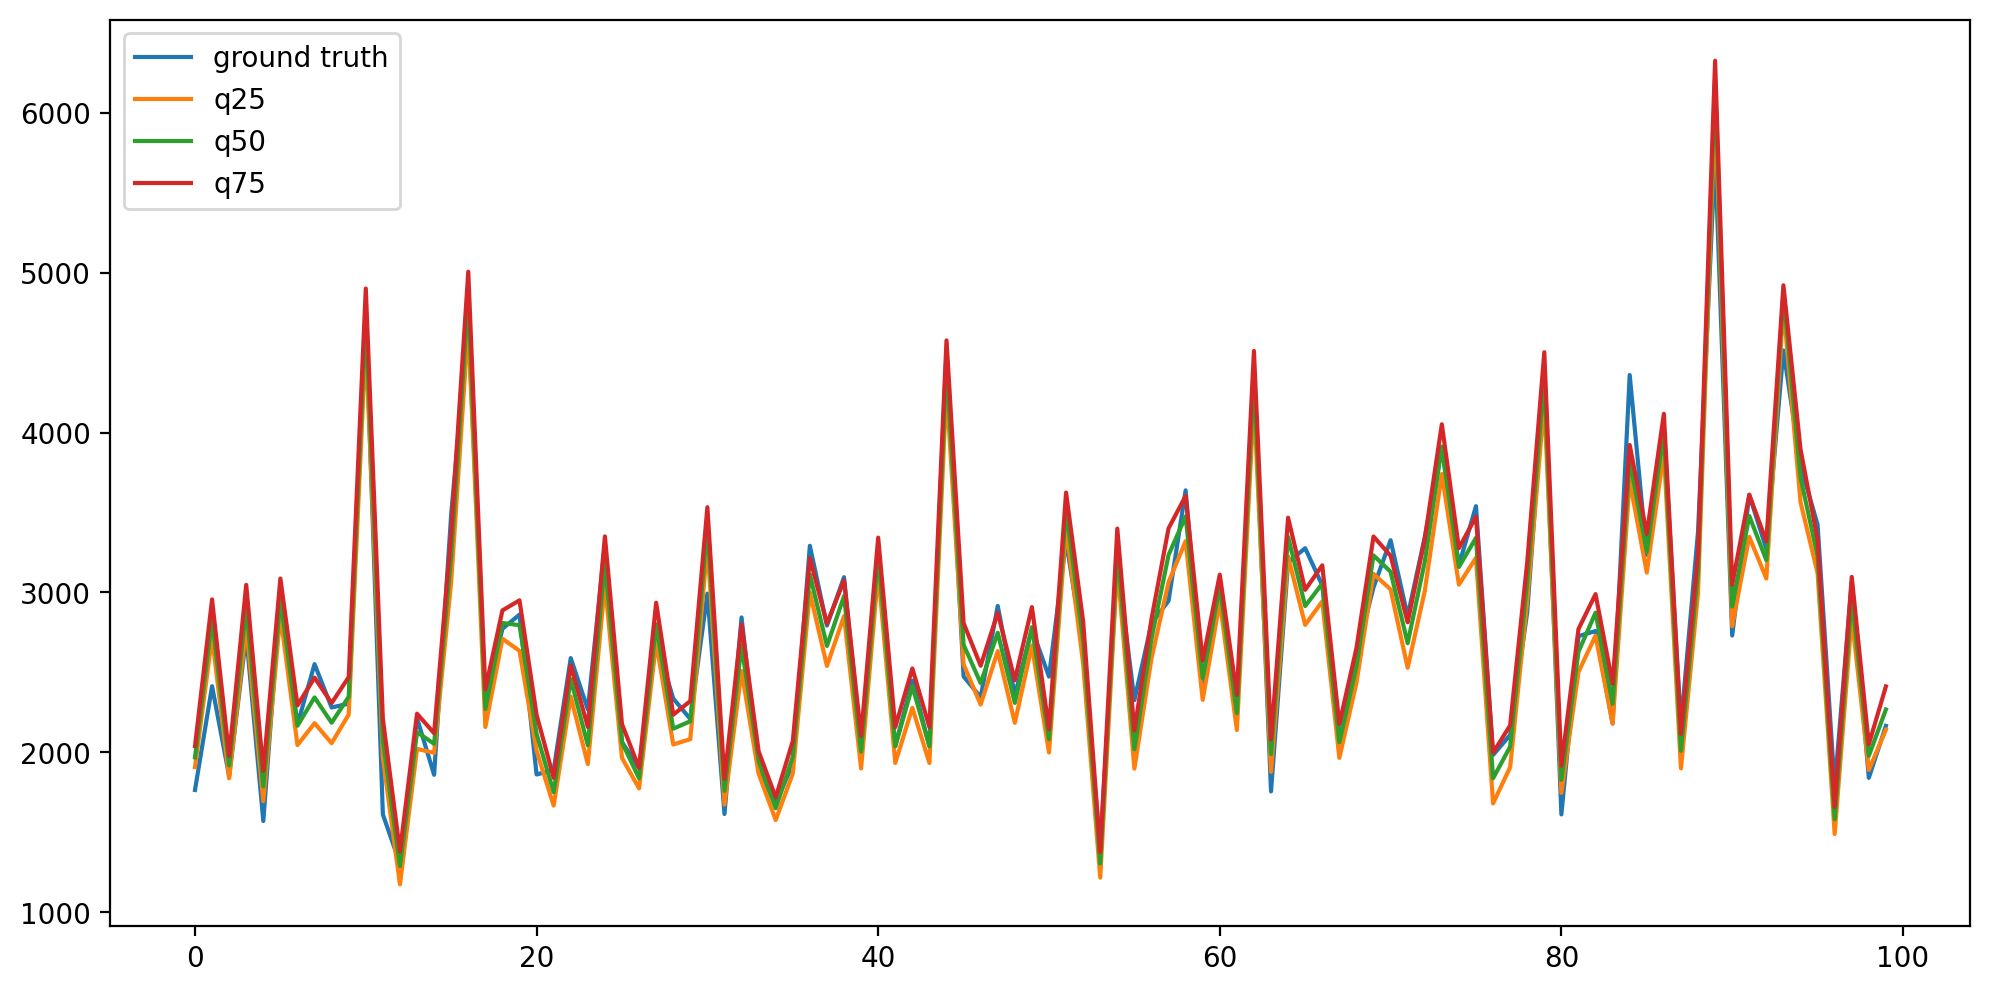

In [36]:
idxs = np.random.randint(0, y.shape[0], 100)
plt.figure(num=None, figsize=(12, 6), dpi=200, facecolor='w', edgecolor='k')
plt.plot(y[idxs], label="ground truth")
plt.plot(pred[idxs, 0], label="q25")
plt.plot(pred[idxs, 1], label="q50")
plt.plot(pred[idxs, 2], label="q75")
plt.legend(loc="best")
plt.show()

In [37]:
idxs.shape

(100,)

In [38]:
print(unc.min(), unc.mean(), unc.max(), (unc>=0).mean())

39.31640625 233.67313379542446 432.6796875 1.0


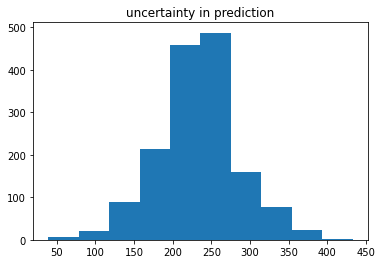

In [39]:
plt.hist(unc)
plt.title("uncertainty in prediction")
plt.show()

In [40]:
sub.head()

,Patient,Weeks,FVC,Percent,Age,Sex,SmokingStatus,WHERE,Confidence,Patient_Week,...,base_week,Male,Female,Ex-smoker,Never smoked,Currently smokes,age,BASE,week,percent
1540,ID00419637202311204720264,-12,3020,70.186855,73,Male,Ex-smoker,test,100.0,ID00419637202311204720264_-12,...,-18.0,1,0,1,0,0,0.615385,0.3724,0.067901,0.332421
1541,ID00419637202311204720264,-11,3020,70.186855,73,Male,Ex-smoker,test,100.0,ID00419637202311204720264_-11,...,-17.0,1,0,1,0,0,0.615385,0.3724,0.074074,0.332421
1542,ID00419637202311204720264,-10,3020,70.186855,73,Male,Ex-smoker,test,100.0,ID00419637202311204720264_-10,...,-16.0,1,0,1,0,0,0.615385,0.3724,0.080247,0.332421
1543,ID00419637202311204720264,-9,3020,70.186855,73,Male,Ex-smoker,test,100.0,ID00419637202311204720264_-9,...,-15.0,1,0,1,0,0,0.615385,0.3724,0.086420,0.332421
1544,ID00419637202311204720264,-8,3020,70.186855,73,Male,Ex-smoker,test,100.0,ID00419637202311204720264_-8,...,-14.0,1,0,1,0,0,0.615385,0.3724,0.092593,0.332421


In [41]:
# PREDICTION
sub['FVC1'] = 1.*pe[:, 1]
sub['Confidence1'] = pe[:, 2] - pe[:, 0]
subm = sub[['Patient_Week','FVC','Confidence','FVC1','Confidence1']].copy()
subm.loc[~subm.FVC1.isnull()].head(10)

/home/prohor/Workspace/anaconda3/envs/osic/lib/python3.6/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

/home/prohor/Workspace/anaconda3/envs/osic/lib/python3.6/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



,Patient_Week,FVC,Confidence,FVC1,Confidence1
1540,ID00419637202311204720264_-12,3020,100.0,2854.745544,232.335632
1541,ID00419637202311204720264_-11,3020,100.0,2852.000000,233.794495
1542,ID00419637202311204720264_-10,3020,100.0,2849.254395,235.253479
1543,ID00419637202311204720264_-9,3020,100.0,2846.508606,236.712402
1544,ID00419637202311204720264_-8,3020,100.0,2843.762939,238.171143
1545,ID00419637202311204720264_-7,3020,100.0,2841.018799,239.626953
1546,ID00419637202311204720264_-6,3020,100.0,2838.276611,241.078247
1547,ID00419637202311204720264_-5,3020,100.0,2835.534302,242.529602
1548,ID00419637202311204720264_-4,3020,100.0,2832.792297,243.981079
1549,ID00419637202311204720264_-3,3020,100.0,2830.049988,245.432251


In [42]:
subm.loc[~subm.FVC1.isnull(),'FVC'] = subm.loc[~subm.FVC1.isnull(),'FVC1']
if sigma_mean<70:
    subm['Confidence'] = sigma_opt
else:
    subm.loc[~subm.FVC1.isnull(),'Confidence'] = subm.loc[~subm.FVC1.isnull(),'Confidence1']

In [43]:
subm.head()

,Patient_Week,FVC,Confidence,FVC1,Confidence1
1540,ID00419637202311204720264_-12,2854.745544,232.335632,2854.745544,232.335632
1541,ID00419637202311204720264_-11,2852.000000,233.794495,2852.000000,233.794495
1542,ID00419637202311204720264_-10,2849.254395,235.253479,2849.254395,235.253479
1543,ID00419637202311204720264_-9,2846.508606,236.712402,2846.508606,236.712402
1544,ID00419637202311204720264_-8,2843.762939,238.171143,2843.762939,238.171143


In [44]:
subm.describe().T

,count,mean,std,min,25%,50%,75%,max
FVC,730.0,2653.167315,316.502566,2022.976074,2606.210297,2693.905182,2816.406784,3199.747375
Confidence,730.0,297.686628,58.486853,174.541901,250.768661,300.058914,346.432320,406.773132
FVC1,730.0,2653.167315,316.502566,2022.976074,2606.210297,2693.905182,2816.406784,3199.747375
Confidence1,730.0,297.686628,58.486853,174.541901,250.768661,300.058914,346.432320,406.773132


In [45]:
otest = pd.read_csv(f'{INPUT_PATH}/test.csv')
for i in range(len(otest)):
    subm.loc[subm['Patient_Week']==otest.Patient[i]+'_'+str(otest.Weeks[i]), 'FVC'] = otest.FVC[i]
    subm.loc[subm['Patient_Week']==otest.Patient[i]+'_'+str(otest.Weeks[i]), 'Confidence'] = 0.1

In [46]:
otest

,Patient,Weeks,FVC,Percent,Age,Sex,SmokingStatus
0,ID00419637202311204720264,6,3020,70.186855,73,Male,Ex-smoker
1,ID00421637202311550012437,15,2739,82.045291,68,Male,Ex-smoker
2,ID00422637202311677017371,6,1930,76.672493,73,Male,Ex-smoker
3,ID00423637202312137826377,17,3294,79.258903,72,Male,Ex-smoker
4,ID00426637202313170790466,0,2925,71.824968,73,Male,Never smoked


In [47]:
subm[subm['Confidence']==0.1]

,Patient_Week,FVC,Confidence,FVC1,Confidence1
1558,ID00419637202311204720264_6,3020.0,0.1,2809.711548,258.185425
1713,ID00421637202311550012437_15,2739.0,0.1,2800.296997,219.153503
1850,ID00422637202311677017371_6,1930.0,0.1,2177.852142,196.420258
2007,ID00423637202312137826377_17,3294.0,0.1,3129.658325,255.012024
2136,ID00426637202313170790466_0,2925.0,0.1,2785.759705,225.475220


In [48]:
subm[["Patient_Week","FVC","Confidence"]].to_csv("submission_regression.csv", index=False)

In [49]:
reg_sub = subm[["Patient_Week","FVC","Confidence"]].copy()